In [1]:
#----------------------------------------------------------------------#
# Lambda event classification dataset creation script

# Data
import numpy as np
import awkward as ak
import pandas as pd
import dask
import dask.dataframe as dd

# I/O
import uproot as ur
import hipopy.hipopy as hp # <--- Package for reading in the hipo files

# Plotting
import matplotlib.pyplot as plt

# Physics
from particle import PDGID

# Miscellaneous
import os
import sys #NOTE: ADDED
import tqdm

# ML Imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch_geometric as tg


In [2]:
#----------------------------------------------------------------------#
# HIPO bank reading and linking functions

def get_bank_keys(bank_name,all_keys,separator='_'):
    """
    :description: Get list of the keys for given bank name from a list of all batch keys.
    
    :param: bank_name
    :param: all_keys
    :param: separator='_'
    
    :return: bank_keys
    """
    bank_keys = []
    for key in all_keys:
        if key.startswith(bank_name+separator):
            bank_keys.append(key)
    return bank_keys
        
def get_event_table(bank_keys,event_num,batch,dtype=float):
    """
    :description: Get a bank event table as a numpy array of shape (number of columns, number of rows).
    
    :param: bank_keys
    :param: event_num
    :param: batch
    :param: dtype=float
    
    :return: bank_table
    """
    bank_table = []
    bank_table = np.moveaxis(np.array([batch[key][event_num] for key in bank_keys], dtype=dtype),[0,1],[1,0])
    return bank_table

def get_link_indices(event_table_rec_particle,event_table,pindex_idx=1):
    """
    :description: Get index pairs linking entries in a bank back to entries in the 'REC::Particle' bank.
    
    :param: event_table_rec_particle
    :param: event_table
    :param: pindex_idx=1
    
    :return: link_indices
    """
    
    link_indices = []
    nrec = np.shape(event_table_rec_particle)[0]
    for rec_particle_idx in range(0,nrec):
        for event_table_idx, el in enumerate(event_table[:,pindex_idx]):
            if el==rec_particle_idx:
                link_indices.append([rec_particle_idx,event_table_idx])
    return np.array(link_indices,dtype=int) #NOTE: link_indices = [(event_table_idx,rec_particle_idx)]

def get_parent_indices(mc_event_table,index_idx=0,parent_idx=4,daughter_idx=5):
    """
    TODO
    """
    for mc_event_table_idx, index in enumerate(mc_event_table[:,index_idx]):
        pass
    pass

def get_match_indices(
    rec_event_table,
    mc_event_table,
    rec_px_idx             = 1,
    rec_py_idx             = 2,
    rec_pz_idx             = 3,
    rec_ch_idx             = 8,
    mc_px_idx              = 6,
    mc_py_idx              = 7,
    mc_pz_idx              = 8,
    mc_pid_idx             = 3,
    mc_daughter_idx        = 5,
    match_charge           = True,
    require_no_mc_daughter = True,
    enforce_uniqueness     = True,
    ):
    """
    :description: Get index pairs matching 
    
    :param: rec_event_table
    :param: mc_event_table
    :param: rec_px_idx             = 1,
    :param: rec_py_idx             = 2,
    :param: rec_pz_idx             = 3,
    :param: rec_ch_idx             = 8,
    :param: mc_px_idx              = 6,
    :param: mc_py_idx              = 7,
    :param: mc_pz_idx              = 8,
    :param: mc_pid_idx             = 3,
    :param: mc_daughter_idx        = 5,
    :param: match_charge           = True,
    :param: require_no_mc_daughter = True,
    :param: enforce_uniqueness     = True,
    
    :return: match_indices
    """
    
    # Set minimum
    rec_final_state_min_idx = 1
    mc_final_state_min_idx  = 3 #NOTE: MC::Lund bank is structured [e, p, q, e', all the other final state particles...]
    
    # Initialize index map
    match_indices    = -np.ones((rec_event_table.shape[0],2),dtype=float)
    match_indices[0] = [0,3] #NOTE: Always match first entry in REC::Particle to scattered electron in MC::Lund.

    # Get REC::Particle info
    rec_px    = rec_event_table[:,rec_px_idx]
    rec_py    = rec_event_table[:,rec_py_idx]
    rec_pz    = rec_event_table[:,rec_pz_idx]
    rec_pT    = np.sqrt(np.square(rec_event_table[:,rec_px_idx])+np.square(rec_event_table[:,rec_py_idx]))
    rec_p     = np.sqrt(np.square(rec_event_table[:,rec_px_idx])+np.square(rec_event_table[:,rec_py_idx])+np.square(rec_event_table[:,rec_pz_idx]))
    rec_theta = np.array(rec_pz)
    rec_theta = np.arctan(rec_pT,rec_theta)
    rec_phi   = np.arctan2(rec_py,rec_px)
    
    # Get MC::Lund info
    mc_px    = mc_event_table[:,mc_px_idx]
    mc_py    = mc_event_table[:,mc_py_idx]
    mc_pz    = mc_event_table[:,mc_pz_idx]
    mc_pT    = np.sqrt(np.square(mc_event_table[:,mc_px_idx])+np.square(mc_event_table[:,mc_py_idx]))
    mc_p     = np.sqrt(np.square(mc_event_table[:,mc_px_idx])+np.square(mc_event_table[:,mc_py_idx])+np.square(mc_event_table[:,mc_pz_idx]))
    mc_theta = np.array(mc_pz)
    mc_theta = np.arctan(mc_pT,mc_theta)
    mc_phi   = np.arctan2(mc_py,mc_px)

    # Loop rec particles
    for rec_idx, rec_part in enumerate(rec_event_table):
        
        # Start with final state particles past scattered electron
        if rec_idx<rec_final_state_min_idx: continue
        
        # Get REC::Particle charge
        rec_ch = rec_event_table[rec_idx,rec_ch_idx]
        
        # Loop mc particles
        mc_match_idx = -1
        min_domega   = 9999
        for mc_idx, mc_part in enumerate(mc_event_table):
            
            # Start with final state particles past scattered electron
            if mc_idx<mc_final_state_min_idx:
                continue
            
            # Enforce unique matching
            if enforce_uniqueness and mc_idx in match_indices[:,1]:
                continue
            
            # Match charge and require that the MC particle be final state (no daughters)
            if match_charge and rec_ch!=PDGID(mc_event_table[mc_idx,mc_pid_idx]).charge:
                continue
            if require_no_mc_daughter and mc_event_table[mc_idx,mc_daughter_idx]!=0:
                continue
                
            # Get angular and momentum differences
            dp     = np.abs(rec_p[rec_idx]     - mc_p[mc_idx])
            dtheta = np.abs(rec_theta[rec_idx] - mc_theta[mc_idx])
            dphi   = np.abs(rec_phi[rec_idx]   - mc_phi[mc_idx]) if np.abs(rec_phi[rec_idx] - mc_phi[mc_idx])<np.pi else 2*np.pi-np.abs(rec_phi[rec_idx] - mc_phi[mc_idx])
            domega = dp**2 + dtheta**2 + dphi**2
            
            # Reset angular, momentum minimum difference
            if domega<min_domega:
                min_domega   = domega
                mc_match_idx = mc_idx
                
        # Append matched index pair
        match_indices[rec_idx] = [rec_idx,mc_match_idx]
        
    return np.array(match_indices,dtype=int) #NOTE: IMPORTANT!

def get_info(base_indices,link_indices,bank_entry_indices,bank_event_table):
    """
    :description: Get selected entry info from other banks linked to REC::Particle.
    
    :param: base_indices
    :param: link_indices #NOTE: if None assume bank is REC::Particle and use identity map
    :param: bank_entry_indices
    :param: bank_event_table
    
    :return: bank_info as awkward.Array
    """
    if link_indices is None:
        bank_info = []
        for base_idx in base_indices:
            base_info = bank_event_table[base_idx,bank_entry_indices]
            bank_info.append([base_info])
            
        return ak.Array(bank_info)
            
    bank_info = []
    for base_idx in base_indices:
        base_info = []
        for rec_particle_idx, link_idx in link_indices:
            if rec_particle_idx==base_idx:
                base_info.append(bank_event_table[link_idx,bank_entry_indices]) #NOTE: INDICES HAVE TO BE INTEGERS...COULD ADD CHECK...
        if len(base_info)==0: #NOTE: Address case that no matches exist between banks
            base_info.append(np.zeros((len(bank_entry_indices),)))
        bank_info.append(base_info)
    
    return ak.Array(bank_info)

def get_truth_info(base_indices,match_indices,truth_entry_indices,mc_event_table):
    """
    :description: Get selected entry info from other banks linked to REC::Particle.
    
    :param: base_indices
    :param: link_indices #NOTE: if None assume bank is REC::Particle and use identity map
    :param: bank_entry_indices
    :param: bank_event_table
    
    :return: bank_info as awkward.Array
    """
    
    bank_info = []
    for base_idx in base_indices:
        base_info = []
        for rec_particle_idx, match_idx in match_indices:
            if rec_particle_idx==base_idx:
                base_info.append(mc_event_table[match_idx,truth_entry_indices]) #NOTE: INDICES HAVE TO BE INTEGERS...COULD ADD CHECK...
        if len(base_info)==0: #NOTE: Address case that no matches exist between banks
            base_info.append(np.zeros((len(truth_entry_indices),)))
        bank_info.append(base_info)
    
    return ak.Array(bank_info)

def check_has_decay(rec_particle_event_table,mc_lund_event_table,match_indices,decay,
                    rec_particle_pid_idx=0,mc_lund_pid_idx=3,mc_lund_parent_idx=4,mc_lund_daughter_idx=5):
    
    """
    :description: Check if specified decay is present in MC::Lund bank and the decay daughters are
        matched to particles of the same pid in REC::Particle
    
    :param: rec_particle_event_table
    :param: mc_lund_event_table
    :param: match_indices
    :param: decay
    :param: rec_particle_pid_idx = 0
    :param: mc_lund_pid_idx      = 3
    :param: mc_lund_parent_idx   = 4
    :param: mc_lund_daughter_idx = 5
    
    :return: boolean has_decay
    """
    
    has_decay = False
    decay_indices = None
    rec_indices = [-1 for i in range(len(decay[1]))] #NOTE: This assumes a 1-level decay...#TODO: Write more robust algorithm.
    if np.max(match_indices[:,-1])==-1: return has_decay, rec_indices #NOTE: This is the case of no matches at all.
    
    # Check if parent pid is in MC::Lund
    if not decay[0] in mc_lund_event_table[:,mc_lund_pid_idx]: return has_decay, rec_indices
    
    # Loop MC::Lund to find parent
    for parent_idx, parent_pid in enumerate(mc_lund_event_table[:,mc_lund_pid_idx]):
        if parent_pid==decay[0]:
#             print("DEBUGGING: found parent_pid == ",decay[0])
            
            # Check daughter pids in MC::Lund
            daughter_idx     = int(mc_lund_event_table[parent_idx,mc_lund_daughter_idx])-1 #NOTE: -1 is important because Lund index begins at 1.
            try:
                daughter_pids    = mc_lund_event_table[daughter_idx:daughter_idx+len(decay[1]),mc_lund_pid_idx]
            except Exception as e:
                print(e)
                print("DEBUGGING: np.shape(mc_lund_event_table) = ",np.shape(mc_lund_event_table))
                print("DEBUGGING: daughter_idx        = ",daughter_idx)
                print("DEBUGGING: decay = ",decay)
                raise Exception
            daughter_parents = mc_lund_event_table[daughter_idx:daughter_idx+len(decay[1]),mc_lund_parent_idx]
            daughter_parents -= 1 #NOTE: Important because Lund index begins at 1.
            if np.all(daughter_parents==parent_idx) and np.all(daughter_pids==decay[1]): #NOTE: this relies on input arrays being np...
                decay_indices = [parent_idx,[daughter_idx+i for i in range(len(decay[1]))]]
                rec_indices = [-1 for i in range(len(decay[1]))]#NOTE: Reset in case you have two not fully matched decays...unlikely but possible.
                
                # Now check that there is a match of the same pid in REC::Particle
                num_matched_daughters = 0
                num_daughters         = len(decay[1])
                for decay_idx, mc_idx in enumerate(decay_indices[1]):
                    for el in match_indices:
                        if el[1]==mc_idx:
                            rec_idx = el[0]
                            if rec_particle_event_table[rec_idx,rec_particle_pid_idx] == decay[1][decay_idx]:
                                num_matched_daughters += 1
                                rec_indices[decay_idx] = rec_idx #NOTE: That this is the actual index beginning at 0.
#                 print("DEBUGGING: num_matched_daughters = ",num_matched_daughters)
#                 print("DEBUGGING: decay_indices = ",decay_indices)
                if num_matched_daughters == num_daughters:
                    has_decay = True
    
    return has_decay, rec_indices

# Select requested rows from REC::Particle data
def get_sub_array(arr,indices):
    
    """
    :description: Get sub array at indices along axis 1.
    
    :param: arr
    :param: indices
    
    :return: np.array new_arr
    """
    
    new_array = []
    for i in indices:
        new_array.append(arr[:,i])
    new_array = np.moveaxis(np.array(new_array),[0,1],[1,0])

    return new_array

def replace_pids(arr,pid_map,pid_i=0):
    """
    :description: Replace pids in given array roughly following scheme described in arxiv:1810.05165.
    
    :param: arr masked ndarray with dtype=float
    :param: pid_i last depth index for pids in arr
    """
    
    if 'int' in str(arr.dtype):
        print(" *** ERROR *** array passed to replace_pids should not have dtype==int")
        return
    
    for key in pid_map:
        arr[:,pid_i] = np.where(arr[:,pid_i]==key,
                                  pid_map[key],
                                  arr[:,pid_i])

def preprocess(x):
    """
    :description: Run preprocessing on input array.
    
    :param: x
    
    :return: new_x
    """
    #NOTE: Assume indices go 0-6 : pid, px, py, pz, beta, chi2pid, status
    
    pid_map = {
        22:0.0,
        11:-1.0,
        -11:1.0,
        2212:0.8,
        -2212:-0.8,
        2112:0.5,
        111:0.1,
        211:0.6,
        -211:-0.6,
        311:0.3,
        321:0.4,
        -321:-0.4,
        45:0.0
    }
    
    pid_idx, px_idx, py_idx, pz_idx, beta_idx, chi2pid_idx, status_idx = [i for i in range(np.shape(x)[-1])]
    
    # Reassign PIDs
    replace_pids(x,pid_map,pid_i=0)
    
    # Compute new arrays
    pT    = np.sqrt(np.add(np.square(x[:,px_idx]),np.square(x[:,py_idx])))
    phi   = np.arctan2(x[:,py_idx],x[:,px_idx])
    theta = np.divide(pT,x[:,pz_idx])
    beta  = np.log(x[:,beta_idx])
    
    #TODO: Compute event level differences and normalize: pT, phi, theta, beta (apply lognorm first though...)
    pT    -= pT.mean()
    pT    /= np.abs(pT).max() if np.abs(pT).max() > 0.0 else 1.0
    phi   -= phi.mean()
    phi   /= np.abs(phi).max() if np.abs(phi).max() > 0.0 else 1.0
    theta -= theta.mean()
    theta /= np.abs(theta).max() if np.abs(theta).max() > 0.0 else 1.0
    beta  -= beta.mean()
    beta  /= np.abs(beta).max() if np.abs(beta).max() > 0.0 else 1.0
    
    # Reset px, py, pz, beta -> pT, phi, theta, beta
    x[:,px_idx]   = pT
    x[:,py_idx]   = phi
    x[:,pz_idx]   = theta
    x[:,beta_idx] = beta
    
#     # Preprocess pT, phi, theta
#     x[:,px_idx] /= 10.0
#     x[:,py_idx] /= np.pi
#     x[:,pz_idx] /= np.pi
    
#     # Preprocess beta variable
#     x[:,beta_idx] -= 1
    
    # Preprocess chi2pid
    chi2_max, chi2_default, chi2_replacement   = 10, 9999, 10 #NOTE: DEBUGGING: USED TO BE >=chi2_default below!
    x[:,chi2pid_idx]  = np.where(x[:,chi2pid_idx]>=chi2_default, chi2_replacement, x[:,chi2pid_idx])
    x[:,chi2pid_idx] /= chi2_max #NOTE: IMPORTANT!  NEEDS TO BE AFTER REPLACEMENT OF MAX ABOVE!
    
    # Preprocess status variable
    x[:,status_idx] /= 5000
    
    # Reassign all data values that are NaN or Inf to zero
    x = np.where(np.isnan(x), 0.0, x)
    x = np.where(np.isinf(x), 0.0, x)
    
    return x

def preprocess_rec_traj(x):
    """
    :description: Run preprocessing on input array assuming it is full matrix of REC::Traj bank.
    
    :param: x
    
    :return: new_x
    """
    #NOTE: Assume indices go 0-10 : pindex, index, detector, layer, x, y, z, cx, cy, cz, path
    
    pindex_idx, index_idx, detector_idx, layer_idx, x_idx, y_idx, z_idx, cx_idx, cy_idx, cz_idx, path_idx = [i for i in range(np.shape(x)[-1])]
    
    # Preprocess row info
#     x[:,x_idx]    -= 0.0
    x[:,x_idx]    /= 1500.0
#     x[:,y_idx]    -= 0.0
    x[:,y_idx]    /= 1500.0
    x[:,z_idx]    -= 1500.0/2
    x[:,z_idx]    /= 1500.0
#     x[:,cx_idx]   -= 0.0
#     x[:,cx_idx]   /= 1.0
#     x[:,cy_idx]   -= 0.0
#     x[:,cy_idx]   /= 1.0
    x[:,cz_idx]   -= 1.0
    x[:,cz_idx]   /= 2.0
    x[:,path_idx] -= 1500.0/2
    x[:,path_idx] /= 1500.0
    
    # Select rows to take #NOTE: Do this after preprocessing so indices make sense
    indices = [x_idx, y_idx, z_idx, cx_idx, cy_idx, cz_idx, path_idx]
    x = np.take(x,indices,axis=1)
    
    # Reassign all data values that are NaN or Inf to zero
    x = np.where(np.isnan(x), 0.0, x)
    x = np.where(np.isinf(x), 0.0, x)
    
    return x

# Test check_has_decay() function
rec_particle_event_table = np.array([[11],[2212],[-211],[-211],[321],[22],[22],[22]])
mc_lund_event_table = np.array([[11,0,0],[2212,0,0],[22,0,0],[11,0,0],[3122,0,6],[2212,5,0],[-211,5,0],[-211,0,0],[-321,0,0],[22,0,0],[22,0,0],[22,0,0]])
match_indices = np.array([[0,3],[1,5],[2,6],[3,7],[4,8],[5,9],[6,10],[7,11]])#NOTE: ALL MATCH
match_indices = np.array([[0,3],[1,-1],[2,6],[3,7],[4,8],[5,9],[6,10],[7,11]])#NOTE: NO PROTON MATCH
match_indices = np.array([[0,3],[1,5],[2,-1],[3,-1],[4,8],[5,9],[6,10],[7,11]])#NOTE: NO PION MATCH
match_indices = np.array([[0,3],[1,5],[2,8],[3,-1],[4,-1],[5,9],[6,10],[7,11]])#NOTE: MATCH PION1 TO KAON, DON'T MATCH PION2 OR KAON
match_indices = np.array([[0,3],[1,10],[2,8],[3,-1],[4,-1],[5,9],[6,-1],[7,11]])#NOTE: MATCH PION1 TO KAON, MATCH PROTON TO PHOTON, DON'T MATCH PION2 OR KAON
decay = [3122,[2212,-211]] #NOTE: ORDERING MATTERS HERE, MUST MATCH ORDER (charge and then mass I think) in MC::Lund bank.
has_decay_test, rec_indices = check_has_decay(rec_particle_event_table,mc_lund_event_table,match_indices,decay,
                                 rec_particle_pid_idx=0,mc_lund_pid_idx=0,mc_lund_parent_idx=1,mc_lund_daughter_idx=2)
print("has_decay_test = ",has_decay_test)
print("rec_indices    = ",rec_indices)

has_decay_test =  False
rec_indices    =  [-1, -1]


In [5]:
#----------------------------------------------------------------------#
# File iteration

# Set input files, banks, and step size
file_list = [
     '/volatile/clas12/users/mfmce/mc_jobs_rga_vtx_3_23_23/analysis2/kinematics_out_skim_50nA_OB_job_3313_0.hipo'
]
banks = [
    'REC::Particle',
    'REC::Traj',
    'REC::Kinematics',
    'MC::Lund',
]
step  = 1000

# Set padding dimension (gets multiplied by len(rec_traj_keys))
max_linked_entries = 30

# Set output dataset and path names
#TODO

# Set entries to use as data/truth
rec_particle_entry_indices   = [0,1,2,3,9,10,11] # pid, px, py, pz, (vx, vy, vz, vt (Only in MC?), charge), beta, chi2pid, status #TODO: SET THESE OUTSIDE LOOPS
rec_kinematics_entry_indices = [i for i in range(11)] # idxe, idxp, idxpi, Q2, nu, W, x, y, z, xF, mass
truth_entry_indices          = [3,4,5] # pid, parent, daughter #TODO: SET THESE OUTSIDE LOOPS

# Iterate hipo file
datalist = []
datalist_flat = []
for batch_num, batch in tqdm.tqdm(enumerate(hp.iterate(file_list,banks=banks,step=step))):
    
    # Set bank names and entry names to look at
    all_keys            = list(batch.keys())
    rec_particle_name   = 'REC::Particle'
    rec_particle_keys   = get_bank_keys(rec_particle_name,all_keys)
    rec_traj_name       = 'REC::Traj'
    rec_traj_keys       = get_bank_keys(rec_traj_name,all_keys)
    rec_kinematics_name = 'REC::Kinematics'
    rec_kinematics_keys = get_bank_keys(rec_kinematics_name,all_keys)
    mc_lund_name        = 'MC::Lund'
    mc_lund_keys        = get_bank_keys(mc_lund_name,all_keys)
    
    # Loop events in batch
    for event_num, _ in enumerate(range(0,len(batch[list(batch.keys())[0]]))):
        
        # Check scattered electron and proton pion in REC::Particle #NOTE: Should prefilter events anyway but check just in case.
        filter_pids  = [2212,-211]
        rec_pid_idx  = 0
        no_filter_pids = True
        count_filter_pids = 0
        for pid in filter_pids:
            if pid in batch['REC::Particle_pid'][event_num]: count_filter_pids += 1
        if count_filter_pids == len(filter_pids): no_filter_pids = False
        if batch['REC::Particle_pid'][event_num][0]!=11 or no_filter_pids: continue #NOTE: Check that particles of interest actually present in event
        
        # Get REC::Particle bank
        rec_particle_event_table = get_event_table(rec_particle_keys,event_num,batch,dtype=float)
        
        # Get REC::Traj bank
        rec_traj_event_table = get_event_table(rec_traj_keys,event_num,batch,dtype=float)
        
        # Get REC::Kinematics bank
        rec_kinematics_event_table = get_event_table(rec_kinematics_keys,event_num,batch,dtype=float)
        
        # Get MC::Lund bank and MC->REC matching indices
        mc_lund_event_table = get_event_table(mc_lund_keys,event_num,batch,dtype=float)
        match_indices  = get_match_indices(rec_particle_event_table,mc_lund_event_table)#TODO: This is somehow resetting rec_particle_event_table...
        
        # Check MC::Lund matched indices for Lambda decay and set event label accordingly
        has_decay, rec_indices = check_has_decay(rec_particle_event_table,mc_lund_event_table,match_indices,decay,
                                   rec_particle_pid_idx=0,mc_lund_pid_idx=3,mc_lund_parent_idx=4,mc_lund_daughter_idx=5)#NOTE: TODO: Decay should be formatted as follows: [parent_pid,[daughter_pid1,daughter_pid2,...]]
        y         = [1] if has_decay==True else [0]

#         ----------------------------------------------------------------------#
#         TODO: Here have 3 options:
#         1. Create pyg graphs EVENT-BY-EVENT                                      -> GNN
#         2. Create awkward arrays of dim (nPions,nBanks(X)nEntries,nCols->PADDED) -> CNN
#         3. Create awkward arrays of dim (nPions,nBanks(X)nEntries*nCols->PADDED) -> NN
#         ----------------------------------------------------------------------#
        
        # Select requested rows from REC::Particle data
        rec_particle_event_x = get_sub_array(rec_particle_event_table,rec_particle_entry_indices)
        
        #TODO: Select which kinematics correspond to MC matched particles...
        #NOTE: This is important because...GNN doesn't tell you which to use though... just tells you if there is a match anywhere...so maybe not necessary...
        
#         print("DEBUGGING: rec_particle_event_table = ",rec_particle_event_table)
#         print("DEBUGGING: rec_particle_event_x     = ",rec_particle_event_x)
#         print("DEBUGGING: mc_lund_event_table      = ",mc_lund_event_table)
#         print("DEBUGGING: has_decay                = ",has_decay)
#         print("DEBUGGING: y                        = ",y)
        
#         # Preprocess data
#         x = preprocess(rec_particle_event_x)
#         x = torch.tensor(x,dtype=torch.float32)
# #         print("DEBUGGING: x = ",x)

        # Preprocess data from REC::Traj instead #NOTE: This also automatically selects subarray
        x = preprocess_rec_traj(rec_traj_event_table)
        x = torch.tensor(x,dtype=torch.float32)
        if torch.abs(x).max()>1.0:
            print("DEBUGGING: torch.where(torch.abs(x)>1.0) = ",torch.where(torch.abs(x)>1.0))
            print("DEBUGGING: torch.abs(x).max()            = ",torch.abs(x).max())
            
        for col in x:
            datalist_flat.append(col.tolist())
            
#         if event_num<5:
#             print(x.shape)
        
        # Define edge index
        num_nodes  = len(x)
        edge_index = torch.tensor([[i,j] for i in range(num_nodes) for j in range(num_nodes)],dtype=torch.long)
#         print("DEBUGGING: edge_index = ",edge_index)
#         print("DEBUGGING: edge_index.t().contiguous() = ",edge_index.t().contiguous())
        
        # Create PyG graph
        data             = tg.data.Data(x=x, edge_index=edge_index.t().contiguous())
        data.y           = torch.tensor(y,dtype=torch.long) #NOTE: Add extra dimension here so that training gets target batch dimension right.
        data.kinematics  = torch.tensor(rec_kinematics_event_table,dtype=torch.float32)
        data.rec_indices = torch.tensor(rec_indices,dtype=torch.long)
        data.pos         = x[:,3:6].clone().detach()
        
        # Add graph to dataset
        datalist.append(data)
        
#         #DEBUGGING: BEGIN
#         print(data)
#         g = tg.utils.to_networkx(data,to_undirected=True)
#         import networkx as nx
#         node_labels = {i:int(val.item()*100) for i, val in enumerate(data.x[:,5])}
#         nx.draw(g,labels=node_labels)
#         #DEBUGGING: END
        
#         break#DEBUGGING
        
#     break#DEBUGGING

49it [03:17,  4.03s/it]


DEBUGGING: np.shape(datalist_flat) =  (2465165, 7)
DEBUGGING: np.shape(datalist_flat) =  (2465165, 7)


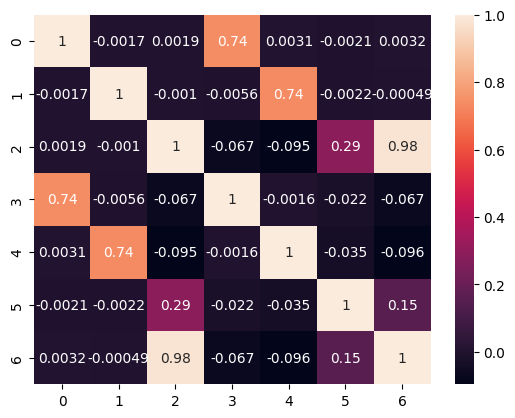

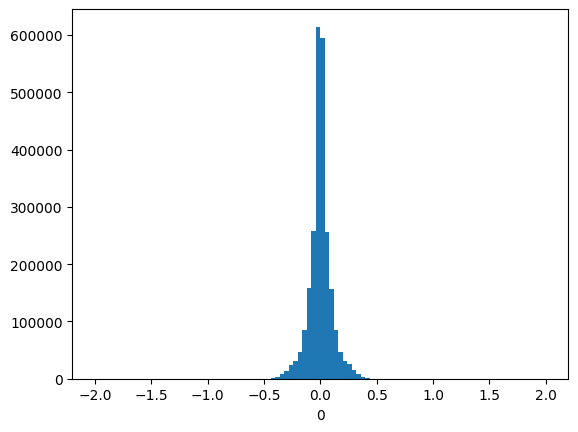

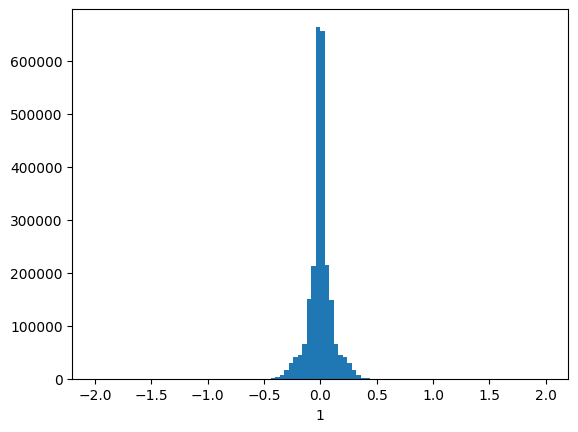

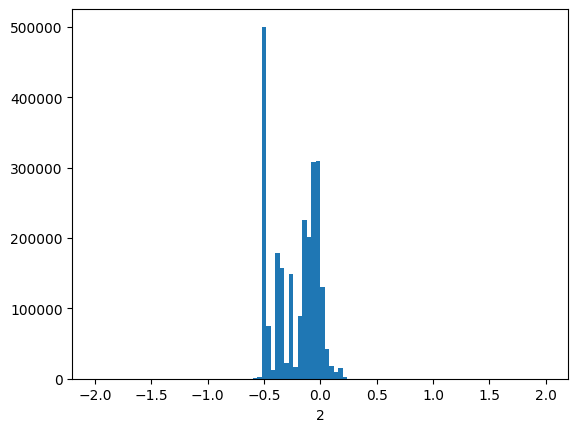

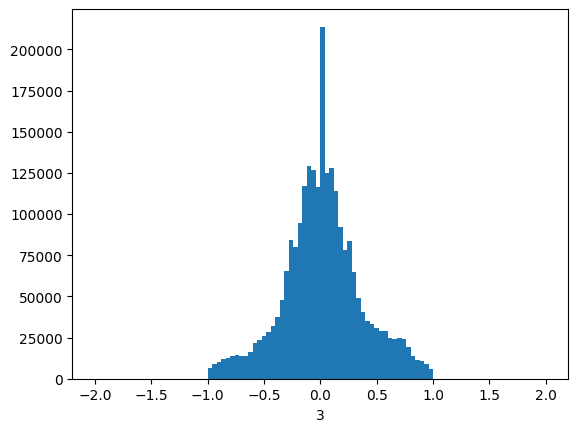

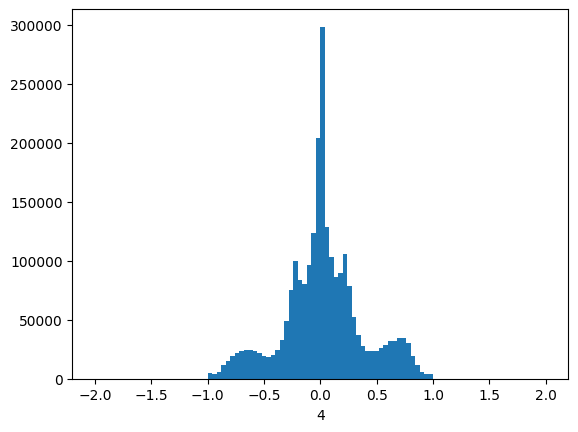

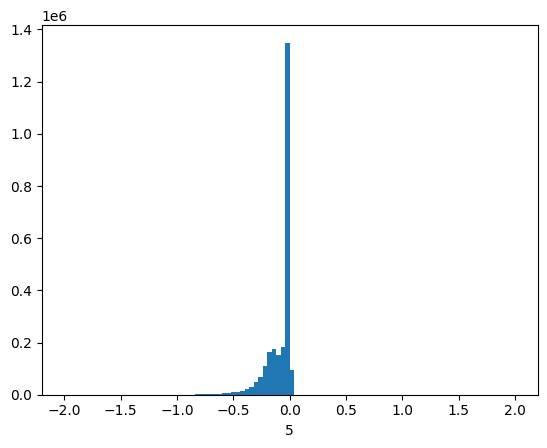

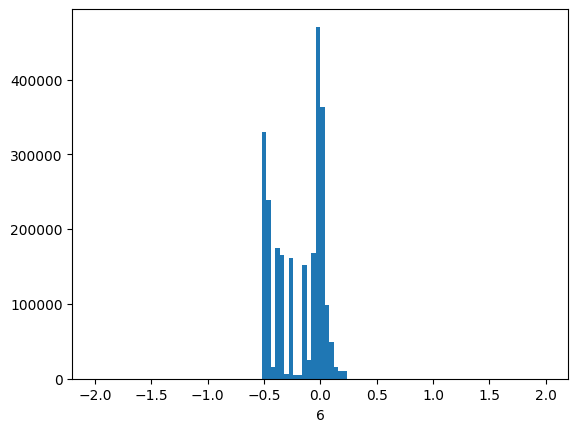

In [6]:
# Plot data and correlations
import seaborn as sns
print("DEBUGGING: np.shape(datalist_flat) = ",np.shape(datalist_flat))
datalist_flat = np.array(datalist_flat,dtype=float)
print("DEBUGGING: np.shape(datalist_flat) = ",np.shape(datalist_flat))

df   = pd.DataFrame(datalist_flat)
corr = df.corr()
sns.heatmap(corr, annot=True)

def get_distribution(arr,label,nbins=100,low_high=(-2.0,2.0)):
    
    f = plt.figure()
    plt.hist(arr,bins=nbins,range=low_high)
    plt.xlabel(label)
    plt.show()
    
for i in range(np.shape(datalist_flat)[-1]):
    get_distribution(datalist_flat[:,i],label=str(i))


In [7]:
import torch
from torch_geometric.data import InMemoryDataset, download_url


class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None, datalist=[]):
        self.datalist = datalist
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])
        # For PyG<2.4:
        # self.data, self.slices = torch.load(self.processed_paths[0])
        

    @property
    def raw_file_names(self):
        return ['some_file_1', 'some_file_2']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        # Read data into huge `Data` list.
        data_list = self.datalist

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])
        # For PyG<2.4:
        # torch.save(self.collate(data_list), self.processed_paths[0])

# Create PyG Dataset
dataset = MyOwnDataset(
            '/work/clas12/users/mfmce/pyg_test_rec_traj_dataset_1_17_23/',
            transform=None,
            pre_transform=None,
            pre_filter=None,
            datalist=datalist
        )

Processing...
Done!


In [8]:
root = '/work/clas12/users/mfmce/pyg_test_rec_traj_dataset_1_17_23/'
### !rm -rf $root/
!mkdir -p $root
!ls -lrth $root/processed

total 284M
-rw-r--r-- 1 mfmce nogroup 2.2G Jan 17 17:11 data.pt
-rw-r--r-- 1 mfmce nogroup  888 Jan 17 17:11 pre_transform.pt
-rw-r--r-- 1 mfmce nogroup  876 Jan 17 17:11 pre_filter.pt


In [10]:
sg_count = 0
for g in dataset:
    if g.y[0].item() == 1: sg_count += 1
        
print("DEBUGGING: sg_count     = ",sg_count)
print("DEBUGGING: len(dataset) = ",len(dataset))
print("DEBUGGING: sg_fraction  = ",sg_count/len(dataset))

DEBUGGING: sg_count     =  5076
DEBUGGING: len(dataset) =  48382
DEBUGGING: sg_fraction  =  0.10491505105204414


In [23]:
DEBUGGING: sg_count     =  5076
DEBUGGING: len(dataset) =  48382
DEBUGGING: sg_fraction  =  0.10491505105204414

has_


In [6]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size, drop_last=True) #NOTE: IMPORTANT TO SET DROP_LAST=TRUE IF DATASET IS NOT PERFECTLY MATCHED WITH BATCH_SIZE
val_dataloader   = DataLoader(val_data,   batch_size=batch_size, drop_last=True)
test_dataloader  = DataLoader(test_data,  batch_size=batch_size, drop_last=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
    
# print("DEBUGGING: len(test_dataloader.dataset) = ",len(test_dataloader.dataset))
# print("DEBUGGING: test_dataloader.dataset[0][1] = ",test_dataloader.dataset[0][1])
# print("DEBUGGING: len(torch.tensor([el[1] for el in test_dataloader.dataset])) = ",len(torch.tensor([el[1] for el in test_dataloader.dataset])))

Shape of X [N, C, H, W]: torch.Size([64, 278])
Shape of y: torch.Size([64, 6]) torch.float32


In [7]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

6871948
858993
858993


In [8]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        x = self.flatten(x)
#         print("DEBUGGING: in model.forward(): x.dtype = ",x.dtype)
#         print("DEBUGGING: type(model.parameters()) = ",type(model.parameters()))
#         print("DEBUGGING: dtypes of model.parameters() = ",[ el.dtype for el in list(model.parameters())])
        logits = self.linear_relu_stack(x)
        return logits

input_dim  = dataset[0][0].shape[-1]
output_dim = dataset[0][1].shape[-1]
print("DEBUGGING: input_dim = ",input_dim)
print("DEBUGGING: output_dim = ",output_dim)
model = NeuralNetwork(input_dim,output_dim).to(device)#.to(torch.float32) <- default for torch model weights is torch.float32
print(model)

Using cuda device
DEBUGGING: input_dim =  278
DEBUGGING: output_dim =  6
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=278, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=6, bias=True)
  )
)


In [9]:
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR, ReduceLROnPlateau
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[10,20], gamma=0.1)
schedulers = [scheduler2]

In [10]:
optimizer.state_dict()['param_groups'][0]['lr']

0.001

In [11]:
def train(dataloader, model, loss_fn, optimizer, epoch_idx):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
#         print("DEBUGGING: batch = ",batch)
        X, y = X.to(device), y.to(device)
#         print("DEBUGGING: X.dtype = ",X.dtype)
#         print("DEBUGGING: np.array(model.weights)",np.array(model.weights).dtype)
        if torch.any(torch.isnan(X)):
            print("FOUND NAN IN INPUT")
        if torch.any(torch.isnan(y)):
            print("FOUND NAN IN LABEL")
        if X.shape[0]!=batch_size:
            print("DEBUGGING: X.shape = ",X.shape)
            print("DEBUGGING: y.shape = ",y.shape)
#         print("DEBUGGING: X.dtype = ",X.dtype)
#         print("DEBUGGING: y.dtype = ",y.dtype)
#         print("DEBUGGING: list(model.parameters())[0]       = ",list(model.parameters())[0])
#         print("DEBUGGING: list(model.parameters())[0].dtype = ",list(model.parameters())[0].dtype)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"\rEpoch {epoch_idx}: Training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]",end="")
            losses.append(loss)
            
    mean_loss = np.mean(losses)
    print(f"\rEpoch {epoch_idx}: Training loss: {mean_loss:>7f}  [{current:>5d}/{size:>5d}]",end="\n")
    
    lr = optimizer.state_dict()['param_groups'][0]['lr']
    
    for s in schedulers:
        s.step()
    return mean_loss, lr

In [12]:
def val(dataloader, model, loss_fn, epoch_idx):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    fractional_diffs = torch.zeros(output_dim).to(device)
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
#             print("DEBUGGING: X.shape = ",X.shape)
#             print("DEBUGGING: y.shape = ",y.shape)
#             print("DEBUGGING: X.dtype = ",X.dtype)
#             print("DEBUGGING: y.dtype = ",y.dtype)
#             print("DEBUGGING: list(model.parameters())[0]       = ",list(model.parameters())[0])
#             print("DEBUGGING: list(model.parameters())[0].dtype = ",list(model.parameters())[0].dtype)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
#             correct = torch.add(fractional_diffs,torch.divide((pred - y),y))
    test_loss /= num_batches
#     correct /= size
    print(f"Epoch {epoch_idx}: Validation loss: {test_loss:>8f}")
    
    return test_loss

In [ ]:
epochs = 40
train_losses = []
val_losses = []
lrs = []
for epoch_idx in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
    train_loss, lr = train(train_dataloader, model, loss_fn, optimizer, epoch_idx)
    val_loss = val(val_dataloader, model, loss_fn, epoch_idx)
#     print("DEBUGGING: type(train_loss) = ",type(train_loss))
#     print("DEBUGGING: type(val_loss) = ",type(val_loss))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    lrs.append(lr)
print("Done!")

Epoch 0: Training loss: 0.000849  [6867264/6871948]
Epoch 0: Validation loss: 0.000681
Epoch 1: Training loss: 0.000681  [6867264/6871948]
Epoch 1: Validation loss: 0.000672
Epoch 2: Training loss: 0.000670  [6867264/6871948]
Epoch 2: Validation loss: 0.000658
Epoch 3: Training loss: 0.000663  [6867264/6871948]
Epoch 3: Validation loss: 0.000658
Epoch 4: Training loss: 0.000657  [6867264/6871948]
Epoch 4: Validation loss: 0.000656
Epoch 5: Training loss: 0.000656  [6867264/6871948]
Epoch 5: Validation loss: 0.000655
Epoch 6: Training loss: 0.000656  [6867264/6871948]
Epoch 6: Validation loss: 0.000661
Epoch 7: Training loss: 0.000653  [6867264/6871948]
Epoch 7: Validation loss: 0.000652
Epoch 8: Training loss: 0.000651  [6867264/6871948]
Epoch 8: Validation loss: 0.000648
Epoch 9: Training loss: 0.000652  [6867264/6871948]
Epoch 9: Validation loss: 0.000655
Epoch 10: Training loss: 0.000624  [6867264/6871948]
Epoch 10: Validation loss: 0.000618
Epoch 11: Training loss: 0.000623  [68672

In [ ]:
f = plt.figure(figsize=(8,5))
plt.semilogy([i for i in range(len(train_losses))],train_losses,color='tab:blue',label='Training Loss')
plt.semilogy([i for i in range(len(train_losses))],val_losses,color='tab:orange',label='Validation Loss')
plt.ylim((5e-4,1e-3))
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='best')
f.savefig('training_metrics.pdf')

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    print("DEBUGGING: size = ",size)
    num_batches = len(dataloader)
    print("DEBUGGING: num_batches = ",num_batches)
    model.eval()
    test_loss = 0
    inputs = None
    preds = None
    tests = None
    correct = None
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
#             print("DEBUGGING: X.shape = ",X.shape)
#             print("DEBUGGING: y.shape = ",y.shape)
#             print("DEBUGGING: X.dtype = ",X.dtype)
#             print("DEBUGGING: y.dtype = ",y.dtype)
#             print("DEBUGGING: list(model.parameters())[0]       = ",list(model.parameters())[0])
#             print("DEBUGGING: list(model.parameters())[0].dtype = ",list(model.parameters())[0].dtype)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            inputs = torch.concatenate((inputs,X),axis=0) if inputs is not None else X
            preds = torch.concatenate((preds,pred),axis=0) if preds is not None else pred
            tests = torch.concatenate((tests,y),axis=0) if tests is not None else y
            correct = torch.concatenate((correct,pred - y),axis=0) if correct is not None else pred - y
    test_loss /= num_batches
#     correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    
    # Copy to CPU
    inputs = inputs.cpu()
    correct = correct.cpu()
    preds = preds.cpu()
    tests = tests.cpu()
    
    print("DEBUGGING: inputs.shape = ",inputs.shape)
    print("DEBUGGING: correct.shape = ",correct.shape)
    print("DEBUGGING: preds.shape = ",preds.shape)
    print("DEBUGGING: tests.shape = ",tests.shape)
    print()
    print("DEBUGGING: correct.min() = ",correct.min().item())
    print("DEBUGGING: preds.min() = ",preds.min().item())
    print("DEBUGGING: tests.min() = ",tests.min().item())
    print()
    print("DEBUGGING: correct.max() = ",correct.max().item())
    print("DEBUGGING: preds.max() = ",preds.max().item())
    print("DEBUGGING: tests.max() = ",tests.max().item())
    print()
    print("DEBUGGING: correct.mean() = ",correct.mean().item())
    print("DEBUGGING: preds.mean() = ",preds.mean().item())
    print("DEBUGGING: tests.mean() = ",tests.mean().item())
    print()
    print("DEBUGGING: correct.std() = ",correct.std().item())
    print("DEBUGGING: preds.std() = ",preds.std().item())
    print("DEBUGGING: tests.std() = ",tests.std().item())
    
    low_high = (-10,10)
    
    # Plot differences between test and prediction
    figs = []
    for j in range(0,3):
        figsize = (8,5)
        f0 = plt.figure(figsize=figsize)
        a0 = plt.hist((inputs[:,j]*10),bins=100,range=low_high)
        plt.xlabel('inputs '+dataset.data_keys[j])
        f0.savefig('inputs_'+dataset.data_keys[j].replace("::","_")+'.pdf')
        
        figsize = (8,5)
        f1 = plt.figure(figsize=figsize)
        a1 = plt.hist((preds[:,j]*10),bins=100,range=low_high)
        plt.xlabel('preds '+dataset.data_keys[j])
        f1.savefig('preds_'+dataset.data_keys[j].replace("::","_")+'.pdf')

        figsize = (8,5)
        f2 = plt.figure(figsize=figsize)
        a2 = plt.hist((tests[:,j]*10),bins=100,range=low_high)
        plt.xlabel(dataset.truth_keys[j])
        f2.savefig(dataset.truth_keys[j].replace("::","_")+'.pdf')

        figsize = (8,5)
        f3 = plt.figure(figsize=figsize)
        a3 = plt.hist((correct[:,j]*10),bins=100,range=low_high)
        plt.xlabel(dataset.data_keys[j]+' - '+dataset.truth_keys[j])
        f3.savefig('dif_'+dataset.data_keys[j].replace("::","_")+'.pdf')
        
        # Print stuff
        print("DEBUGGING: target label = ",dataset.truth_keys[j])
        print("DEBUGGING: mean Delta   = ",correct[:,j].mean()*10)
        print("DEBUGGING: std Delta    = ",correct[:,j].std()*10)
        
        # Get original diffs
        original_deltas = np.subtract(inputs[:,j],tests[:,j])
        print("DEBUGGING: mean orig Delta   = ",original_deltas.mean()*10)
        print("DEBUGGING: std orig Delta    = ",original_deltas.std()*10)
        
        figs.extend([f0,f1,f2,f3])
    
    low_high = (-100,100)
    
    # Plot differences between test and prediction
    for j in range(3,6):
        figsize = (8,5)
        f0 = plt.figure(figsize=figsize)
        a0 = plt.hist((inputs[:,j]*50)-25,bins=100,range=low_high)
        plt.xlabel('inputs '+dataset.data_keys[j])
        f0.savefig('inputs_'+dataset.data_keys[j].replace("::","_")+'.pdf')
        
        figsize = (8,5)
        f1 = plt.figure(figsize=figsize)
        a1 = plt.hist((preds[:,j]*50)-25,bins=100,range=low_high)
        plt.xlabel('preds '+dataset.data_keys[j])
        f1.savefig('preds_'+dataset.data_keys[j].replace("::","_")+'.pdf')

        figsize = (8,5)
        f2 = plt.figure(figsize=figsize)
        a2 = plt.hist((tests[:,j]*50)-25,bins=100,range=low_high)
        plt.xlabel(dataset.truth_keys[j])
        f2.savefig(dataset.truth_keys[j].replace("::","_")+'.pdf')

        figsize = (8,5)
        f3 = plt.figure(figsize=figsize)
        a3 = plt.hist((correct[:,j]*50),bins=100,range=low_high)
        plt.xlabel(dataset.data_keys[j]+' - '+dataset.truth_keys[j])
        f3.savefig('dif_'+dataset.data_keys[j].replace("::","_")+'.pdf')
        
        # Print stuff
        print("DEBUGGING: target label = ",dataset.truth_keys[j])
        print("DEBUGGING: mean Delta   = ",correct[:,j].mean()*10)
        print("DEBUGGING: std Delta    = ",correct[:,j].std()*10)
        
        # Get original diffs
        original_deltas = np.subtract(inputs[:,j],tests[:,j])
        print("DEBUGGING: mean orig Delta   = ",original_deltas.mean()*10)
        print("DEBUGGING: std orig Delta    = ",original_deltas.std()*10)
        
        figs.extend([f0,f1,f2,f3])
        
    plt.show()
    
test(test_dataloader, model, loss_fn)

In [58]:
print(len(train_dataloader))

4908
